[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sineeli/GANs-JAX/blob/main/GAN(JAX).ipynb)

## Import Necessary Libraries

In [ ]:
import jax
import numpy as np
import jax.numpy as jnp
from jax import random, grad
import flax.linen as nn
from flax.training import train_state
import optax
import tensorflow as tf
import tensorflow_datasets as tfds
import flax

from typing import Any
from functools import partial
import matplotlib.pyplot as plt

## Base Parameters

In [ ]:
# Settings
batch_size = 128
epochs = 20
learning_rate = 0.0002
noise_dim = 512
label_smoothing = 0.95

# Create random seed
key = random.PRNGKey(0)

## Generator Model

In [ ]:
class Generator(nn.Module):
  @nn.compact
  def __call__(self, z):
    x = nn.Dense(256)(z)
    x = nn.leaky_relu(x, 0.2)
    x = nn.Dense(512)(x)
    x = nn.leaky_relu(x, 0.2)
    x = nn.Dense(1024)(x)
    x = nn.leaky_relu(x, 0.2)
    x = nn.Dense(28*28)(x)
    x = nn.tanh(x)
    return x.reshape((-1, 28, 28, 1))

## Discriminator Model

In [ ]:
class Discriminator(nn.Module):
  @nn.compact
  def __call__(self, x):
    x = x.reshape((-1, 28*28))
    x = nn.Dense(1024)(x)
    x = nn.leaky_relu(x, 0.2)
    x = nn.Dense(512)(x)
    x = nn.leaky_relu(x, 0.2)
    x = nn.Dense(256)(x)
    x = nn.leaky_relu(x, 0.2)
    x = nn.Dense(1)(x)
    return x

## Discriminator Training Step

In [ ]:
@partial(jax.jit, static_argnames=['batch_size'])
def discriminator_step(generator_state,
                       discriminator_state,
                       real_data,
                       batch_size,
                       key):
  """
    Perform a single training step for the discriminator in a GAN.

    This function generates fake images using the generator, combines them with real data,
    and updates the discriminator's parameters based on the computed loss.

    Args:
        generator_state (TrainState): The current state of the generator, including parameters.
        discriminator_state (TrainState): The current state of the discriminator, including parameters.
        real_data (jax.numpy.ndarray): The batch of real data.
        batch_size (int): The size of the batch.
        key (jax.random.PRNGKey): A key for random number generation in JAX.

    Returns:
        Tuple[TrainState, jnp.ndarray]: A tuple containing the updated discriminator state and the computed loss.
  """
  def disc_loss_fn(params_disc, x, y):
    # Apply the discriminator model to input data x with parameters params_disc
    y_pred = discriminator.apply({'params': params_disc}, x)
    # Calculate the binary cross-entropy loss
    loss = optax.sigmoid_binary_cross_entropy(y_pred, y).mean()
    return loss

  # Generate random noise and produce fake images using the generator
  z = random.normal(key, (batch_size, noise_dim))
  fake_images = generator.apply({'params': generator_state.params}, z)

  # Create fake labels (0) and real labels (1, with label smoothing)
  fake_labels = jnp.zeros((batch_size, 1), float)
  real_labels = label_smoothing * jnp.ones((batch_size, 1), float)

  # Combine real and fake labels, as well as real and fake images
  combined_labels = jnp.concatenate([real_labels, fake_labels], axis=0)
  combined_images = jnp.concatenate([data, fake_images], axis=0)

  # Define a gradient function for the discriminator loss
  grad_fn = jax.value_and_grad(disc_loss_fn)
  # Compute the loss and gradients for the combined real and fake data
  loss, grads = grad_fn(discriminator_state.params,
                        combined_images,
                        combined_labels)

  # Update the discriminator state with the computed gradients
  new_discriminator_state = discriminator_state.apply_gradients(grads=grads)

  return new_discriminator_state, loss

## Generator Training Step

In [ ]:
@partial(jax.jit, static_argnames=['batch_size'])
def generator_step(generator_state,
                   discriminator_state,
                   batch_size,
                   key):
  """
    Perform a single step of training on the generator in a GAN setup.

    This function computes the loss for the generator based on the output of the discriminator,
    updates the generator's parameters using the computed gradients, and returns the updated
    generator state along with the loss.

    Args:
        generator_state (TrainState): The current state of the generator, including parameters.
        discriminator_state (TrainState): The current state of the discriminator, including parameters.
        batch_size (int): The size of the batch to generate.
        key (jax.random.PRNGKey): A key for random number generation in JAX.

    Returns:
        Tuple[TrainState, jnp.ndarray]: A tuple containing the updated generator state and the computed loss.
  """

  def gen_loss_fn(params, z):
    # Generate fake images using the current generator parameters
    fake_images = generator.apply({'params': params}, z)
    # Compute the discriminator's logits for these fake images
    logits = discriminator.apply({'params': discriminator_state.params}, fake_images)
    # Calculate the generator's loss as the negative log likelihood
    loss = -jnp.mean(jnp.log(nn.sigmoid(logits)))

    return loss

  # Generate random noise as input for the generator
  z = random.normal(key, (batch_size, noise_dim))
  # Define a function to compute both the loss and gradients for the generator
  grad_fn = jax.value_and_grad(gen_loss_fn)
  # Calculate the loss and gradients based on the current generator parameters
  loss, grads = grad_fn(generator_state.params, z)
  # Update the generator state with the computed gradients
  new_generator_state = generator_state.apply_gradients(grads=grads)

  return new_generator_state, loss


## Intialize and Get Model Parameters

In [ ]:
# Initialize generator
z = random.normal(key, (batch_size, noise_dim))
generator = Generator()
params_gen = generator.init(key, z)['params']

# Initialize discriminator
discriminator = Discriminator()
params_disc = discriminator.init(key, jnp.ones([1, 28, 28, 1]))['params']

# Optimizers
tx_gen = optax.adam(learning_rate, b1=0.5)
tx_disc = optax.adam(learning_rate, b1=0.5)

# Training state
generator_state = train_state.TrainState.create(apply_fn=generator.apply, params=params_gen, tx=tx_gen)
discriminator_state = train_state.TrainState.create(apply_fn=discriminator.apply, params=params_disc, tx=tx_disc)


## Load MNIST Dataset

In [ ]:
def set_range(batch):
  batch = tf.image.convert_image_dtype(batch['image'], tf.float32)
  batch = (batch - 0.5) / 0.5  # tanh range is -1, 1
  return batch


mnist_data = tfds.load("mnist")['train']
batches_in_epoch = len(mnist_data) // batch_size

data_gen = iter(tfds.as_numpy(
      mnist_data
        .map(set_range)
        .cache()
        .shuffle(len(mnist_data), seed=42)
        .batch(batch_size)
 ))

## Train the GAN network

In [ ]:
# Iterating over batches of data
for data in data_gen:
  # Splitting the random key into three parts for different purposes
  key, key_generator, key_discriminator = jax.random.split(key, 3)

  # Updating the generator state and calculating its loss
  # The generator's loss and state are updated based on the discriminator's current state
  # and the batch size determined by the current data
  generator_state, generator_loss = generator_step(generator_state,
                                                  discriminator_state,
                                                  data.shape[0],
                                                  key_generator)

  # Updating the discriminator state and calculating its loss
  # The discriminator's loss and state are updated based on both the generator's state
  # and the real data from the current batch
  discriminator_state, discriminator_loss = discriminator_step(generator_state,
                                                              discriminator_state,
                                                              data,
                                                              data.shape[0],
                                                              key)

  message = f"Generator loss: {generator_loss:.3f} | "
  message += f"Discriminator loss: {discriminator_loss:.3f}"
  print(message)

Generator loss: 0.736 | Discriminator loss: 0.796
Generator loss: 0.657 | Discriminator loss: 0.600
Generator loss: 0.624 | Discriminator loss: 0.568
Generator loss: 0.627 | Discriminator loss: 0.563
Generator loss: 0.649 | Discriminator loss: 0.541
Generator loss: 0.694 | Discriminator loss: 0.517
Generator loss: 0.768 | Discriminator loss: 0.485
Generator loss: 0.850 | Discriminator loss: 0.453
Generator loss: 0.927 | Discriminator loss: 0.431
Generator loss: 0.994 | Discriminator loss: 0.421
Generator loss: 1.034 | Discriminator loss: 0.420
Generator loss: 1.082 | Discriminator loss: 0.433
Generator loss: 1.105 | Discriminator loss: 0.453
Generator loss: 1.076 | Discriminator loss: 0.491
Generator loss: 1.034 | Discriminator loss: 0.515
Generator loss: 1.027 | Discriminator loss: 0.535
Generator loss: 1.036 | Discriminator loss: 0.532
Generator loss: 1.103 | Discriminator loss: 0.508
Generator loss: 1.165 | Discriminator loss: 0.485
Generator loss: 1.268 | Discriminator loss: 0.466


## Generate Images

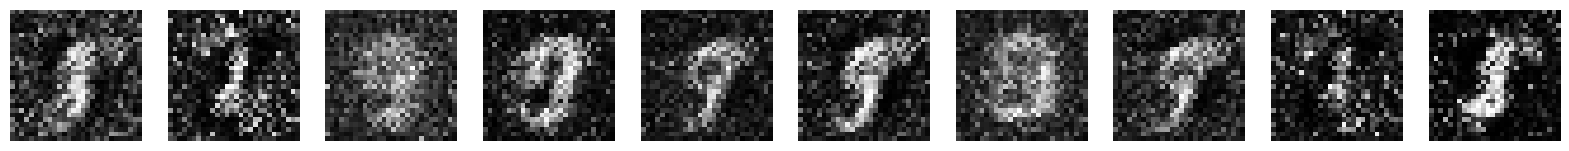

In [ ]:
# Generate images
z = np.random.randn(16, noise_dim)
generated_images = generator.apply({'params': generator_state.params}, z)

def show_generated_images(generated_images, num_images=10):
    # Assuming generated_images is a numpy array of shape (n, height, width)
    # We will display 'num_images' images in a grid

    plt.figure(figsize=(20, 20))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(generated_images[i].squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()

# Call the function with your generated images
# Replace 'generated_images' with your actual array of generated images
show_generated_images(generated_images)
